In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
from PIL import Image
import cv2

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.Grayscale()])

In [7]:
dataset = datasets.ImageFolder("archive (1)\Brain Tumor Data Set\Brain Tumor Data Set", transform=transform)
class_name = dataset.classes

In [8]:
train_size = int(0.7*(len(dataset)))
test_size = int(0.3*(len(dataset)))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [9]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=10)

Label: [0 1 1 0 0 0 0 0 1 1]
Class: Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Brain Tumor Brain Tumor Healthy Healthy


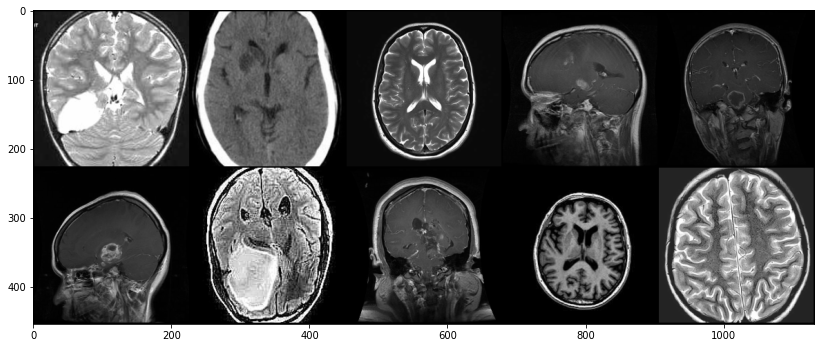

In [10]:
for image, label in train_loader:
    break

print('Label:', label.numpy())
print('Class:', *np.array([class_name[i] for i in label]))

# the default nrow is 8
im = make_grid(image, nrow=5)  

# Print the images
plt.figure(figsize=(14,6))
plt.imshow(np.transpose(im, (1, 2, 0)))

In [114]:
conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=3)
conv2 = nn.Conv2d(16, 36, kernel_size=2, stride=3)
conv3 = nn.Conv2d(16, 30, kernel_size=2, stride=2)
dropout = nn.Dropout(0.5)
fc1 = nn.Linear(7*7*64, 120)
fc2 = nn.Linear(120, 2)

In [115]:
for i , (X_train,Y_train) in enumerate(train_loader):
    break

In [116]:
X_train.shape

torch.Size([10, 1, 224, 224])

In [117]:
X = F.relu(conv1(X_train))
X = dropout(X)
X = F.max_pool2d(X, 2, 2)
X = F.relu(conv2(X))
X = dropout(X)
X = F.max_pool2d(X, 2, 2)
# X = F.relu(conv3(X))
# X = dropout(X)
# X = F.max_pool2d(X, 2, 2)
# X = F.relu(conv4(X))
# X = dropout(X)
# X = F.max_pool2d(X, 2, 2)


In [118]:
X.shape

torch.Size([10, 36, 6, 6])

In [119]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=3)
        self.conv2 = nn.Conv2d(16, 36, kernel_size=2, stride=3)
        # self.conv3 = nn.Conv2d(16, 30, kernel_size=2, stride=2)
        # self.fc1 = nn.Linear(16*6*6, )
        self.fc2 = nn.Linear(36*6*6, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        # X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        # X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        # X = F.relu(self.conv3(X))
        # X = F.max_pool2d(X, 2, 2)
        # X = F.relu(self.conv4(X))
        # X = self.dropout(X)
        # X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 36*6*6)
        # X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return F.log_softmax(X, dim=1)

In [120]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [121]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

    64
    16
  2304
    36
  2592
     2
______
  5014


In [ ]:
# len(train_loader)
'bleh'

322

In [123]:
len(test_loader)

138

In [124]:
epoch = 30
losses = []
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epoch):
    trn_corr = 0
    tst_corr = 0

    for b,(x_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(x_train)
        loss = criterion(y_pred,y_train)
     
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%64 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/3200]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
    
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

epoch:  0  batch:   64 [   640/3200]  loss: 0.40698010 accuracy:  57.656%
epoch:  0  batch:  128 [  1280/3200]  loss: 0.53724265 accuracy:  61.328%
epoch:  0  batch:  192 [  1920/3200]  loss: 0.56821382 accuracy:  64.115%
epoch:  0  batch:  256 [  2560/3200]  loss: 0.52754706 accuracy:  65.430%
epoch:  0  batch:  320 [  3200/3200]  loss: 0.64744890 accuracy:  66.719%
epoch:  1  batch:   64 [   640/3200]  loss: 0.50717300 accuracy:  72.344%
epoch:  1  batch:  128 [  1280/3200]  loss: 0.38292629 accuracy:  75.000%
epoch:  1  batch:  192 [  1920/3200]  loss: 0.51887673 accuracy:  75.781%
epoch:  1  batch:  256 [  2560/3200]  loss: 0.51814115 accuracy:  76.289%
epoch:  1  batch:  320 [  3200/3200]  loss: 0.52613294 accuracy:  76.719%
epoch:  2  batch:   64 [   640/3200]  loss: 0.43572122 accuracy:  81.094%
epoch:  2  batch:  128 [  1280/3200]  loss: 0.21802087 accuracy:  79.531%
epoch:  2  batch:  192 [  1920/3200]  loss: 0.59583604 accuracy:  78.906%
epoch:  2  batch:  256 [  2560/3200]  

In [84]:
# li = []
# with torch.no_grad():
#     for b, (X_test, y_test) in enumerate(test_loader):

#         # Apply the model
#         y_val = model(X_test)

#         # Tally the number of correct predictions
#         predicted = torch.max(y_val.data, 1)[1] 
#         tst_corr += (predicted == y_test).sum()
#         li.append(tst_corr.item()*100/len(test_loader)*10)

In [125]:
for i in range(len(test_correct)):
    print(test_correct[i].item(),i,(test_correct[i].item()*100/(len(test_loader)*10)))
print(f'Test accuracy: {test_correct[-1].item()*100/(len(test_loader)*10):.3f}%')

1033 0 74.85507246376811
1036 1 75.07246376811594
1062 2 76.95652173913044
1126 3 81.59420289855072
1117 4 80.94202898550725
1123 5 81.3768115942029
1155 6 83.69565217391305
1120 7 81.15942028985508
1161 8 84.1304347826087
1195 9 86.59420289855072
1194 10 86.52173913043478
1168 11 84.6376811594203
1206 12 87.3913043478261
1230 13 89.1304347826087
1239 14 89.78260869565217
1225 15 88.76811594202898
1234 16 89.42028985507247
1234 17 89.42028985507247
1228 18 88.98550724637681
1202 19 87.10144927536231
1260 20 91.30434782608695
1249 21 90.5072463768116
1274 22 92.31884057971014
1271 23 92.10144927536231
1236 24 89.56521739130434
1278 25 92.6086956521739
1237 26 89.6376811594203
1280 27 92.7536231884058
1284 28 93.04347826086956
1286 29 93.18840579710145
Test accuracy: 93.188%


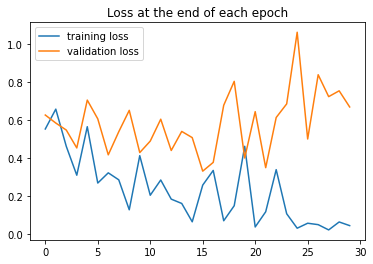

In [126]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

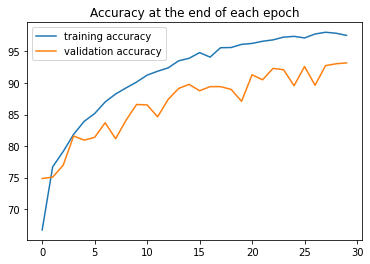

In [127]:
plt.plot([10*t/len(train_loader) for t in train_correct], label='training accuracy')
plt.plot([10*t/len(test_loader) for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()